In [1]:
import numpy as np 
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 100)
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from ipywidgets import widgets
from ydata_profiling import ProfileReport
from ydata_profiling.utils.cache import cache_file

/Users/claudiacastro/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# cargando el dataset de productos desde S3 de AWS
prod_df = pd.read_parquet('https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/products_df.parquet')

# sdg_df = pd.read_parquet('https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/sociodemographic_df.parquet')

# Productos

In [3]:
prod_df

,Unnamed: 0,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
0,0,1375586,2018-01-28,0,0,0,0,0,0,0,0,0.000,0.000,0,0,0,0,1
1,1,1050611,2018-01-28,0,0,0,0,0,0,0,0,0.000,0.000,0,0,0,0,1
2,2,1050612,2018-01-28,0,0,0,0,0,0,0,0,0.000,0.000,0,0,0,0,1
3,3,1050613,2018-01-28,1,0,0,0,0,0,0,0,0.000,0.000,0,0,0,0,0
4,4,1050614,2018-01-28,0,0,0,0,0,0,0,0,0.000,0.000,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,13647304,1166765,2019-05-28,0,0,0,0,0,0,0,0,0.000,0.000,0,0,0,0,1
5962920,13647305,1166764,2019-05-28,0,0,0,0,0,0,0,0,0.000,0.000,0,0,0,0,1
5962921,13647306,1166763,2019-05-28,0,0,0,0,0,0,0,0,0.000,0.000,0,0,0,0,1
5962922,13647307,1166789,2019-05-28,0,0,0,0,0,0,0,0,0.000,0.000,0,0,0,0,1


## Análisis preliminar

In [4]:
prod_df.isna().sum()

Unnamed: 0             0
pk_cid                 0
pk_partition           0
short_term_deposit     0
loans                  0
mortgage               0
funds                  0
securities             0
long_term_deposit      0
em_account_pp          0
credit_card            0
payroll               61
pension_plan          61
payroll_account        0
emc_account            0
debit_card             0
em_account_p           0
em_acount              0
dtype: int64

Se observan 61 nulos en pension_plan y en payroll en un dataset de más de 5 milliones de filas. 

Se reemplazarán utilizando la moda.

In [5]:
# reeplazamos los valores nulos por la moda
prod_df['payroll'].fillna(prod_df['payroll'].mode()[0], inplace=True)
prod_df['pension_plan'].fillna(prod_df['pension_plan'].mode()[0], inplace=True)
# comprobamos que no haya valores nulos
prod_df.isna().sum().sum()


0

In [6]:
# presencia de duplicados
prod_df.duplicated().sum()

0

In [7]:
# eliminamos columnas que no aportan información
prod_df = prod_df.drop(columns=['Unnamed: 0'], axis=1)

In [8]:
variables = [
    'short_term_deposit', 'loans', 'mortgage', 'funds', 'securities',
    'long_term_deposit', 'em_account_pp', 'credit_card', 'payroll',
    'pension_plan', 'payroll_account', 'emc_account', 'debit_card',
    'em_account_p', 'em_acount'
]

# modificamos el tipo de dato de las columnas para optimizar el uso de memoria y mejorar la eficiencia
for var in variables:
    prod_df[var] = prod_df[var].astype('int8')
prod_df["pk_partition"] = pd.to_datetime(prod_df["pk_partition"])

In [9]:
# comprobamos que se haya realizado el cambio correctamente
prod_df.dtypes

pk_cid                         int64
pk_partition          datetime64[ns]
short_term_deposit              int8
loans                           int8
mortgage                        int8
funds                           int8
securities                      int8
long_term_deposit               int8
em_account_pp                   int8
credit_card                     int8
payroll                         int8
pension_plan                    int8
payroll_account                 int8
emc_account                     int8
debit_card                      int8
em_account_p                    int8
em_acount                       int8
dtype: object

In [10]:
# Lista de variables a analizar
variables = [
    'short_term_deposit', 'loans', 'mortgage', 'funds', 'securities',
    'long_term_deposit', 'em_account_pp', 'credit_card', 'payroll',
    'pension_plan', 'payroll_account', 'emc_account', 'debit_card',
    'em_account_p', 'em_acount'
]

# Crear un diccionario para almacenar los resultados de cada variable
resultados = {}

for var in variables:
    print(f"\nAnalizando la variable: {var}")
    
    # Contar cuántos valores únicos tiene cada cliente para la variable actual
    estado_por_cliente = prod_df.groupby('pk_cid')[var].nunique()

    # Identificar clientes con valores mixtos (múltiples valores en la variable)
    clientes_mixtos = estado_por_cliente[estado_por_cliente > 1].index

    # Excluir los clientes mixtos del análisis de las otras categorías
    df_no_mixtos = prod_df[~prod_df['pk_cid'].isin(clientes_mixtos)]

    # Identificar clientes que tienen siempre el mismo valor
    clientes_mismo_valor = df_no_mixtos.groupby('pk_cid')[var].nunique()
    clientes_mismo_valor = clientes_mismo_valor[clientes_mismo_valor == 1].index

    # Filtrar clientes que siempre tienen 0 o siempre tienen 1
    siempre_cero = df_no_mixtos[df_no_mixtos['pk_cid'].isin(clientes_mismo_valor) & (df_no_mixtos[var] == 0)]
    siempre_uno = df_no_mixtos[df_no_mixtos['pk_cid'].isin(clientes_mismo_valor) & (df_no_mixtos[var] == 1)]

    # Contar el número de clientes en cada categoría (excluyendo mixtos)
    n_siempre_cero = len(siempre_cero['pk_cid'].unique())
    n_siempre_uno = len(siempre_uno['pk_cid'].unique())
    n_mixtos = len(clientes_mixtos)

    # Almacenar los resultados en el diccionario
    resultados[var] = {
        'siempre_cero': n_siempre_cero,
        'siempre_uno': n_siempre_uno,
        'mixtos': n_mixtos
    }

    # Mostrar los resultados para la variable actual
    print(f"Clientes que siempre tienen 0 en '{var}': {n_siempre_cero}")
    print(f"Clientes que siempre tienen 1 en '{var}': {n_siempre_uno}")
    print(f"Clientes con valores mixtos en '{var}' (diferentes valores): {n_mixtos}")


Analizando la variable: short_term_deposit
Clientes que siempre tienen 0 en 'short_term_deposit': 451049
Clientes que siempre tienen 1 en 'short_term_deposit': 2
Clientes con valores mixtos en 'short_term_deposit' (diferentes valores): 5322

Analizando la variable: loans
Clientes que siempre tienen 0 en 'loans': 456329
Clientes que siempre tienen 1 en 'loans': 12
Clientes con valores mixtos en 'loans' (diferentes valores): 32

Analizando la variable: mortgage
Clientes que siempre tienen 0 en 'mortgage': 456348
Clientes que siempre tienen 1 en 'mortgage': 13
Clientes con valores mixtos en 'mortgage' (diferentes valores): 12

Analizando la variable: funds
Clientes que siempre tienen 0 en 'funds': 454707
Clientes que siempre tienen 1 en 'funds': 612
Clientes con valores mixtos en 'funds' (diferentes valores): 1054

Analizando la variable: securities
Clientes que siempre tienen 0 en 'securities': 454284
Clientes que siempre tienen 1 en 'securities': 790
Clientes con valores mixtos en 'sec

OJOOOO




In [11]:
# Lista de variables a analizar
variables = [
    'short_term_deposit', 'loans', 'mortgage', 'funds', 'securities',
    'long_term_deposit', 'em_account_pp', 'credit_card', 'payroll',
    'pension_plan', 'payroll_account', 'emc_account', 'debit_card',
    'em_account_p', 'em_acount'
]

# Crear un diccionario para almacenar los resultados de cada variable
resultados = {}

for var in variables:
    print(f"\nAnalizando la variable: {var}")
    
    # Contar cuántos valores únicos tiene cada cliente para la variable actual
    estado_por_cliente = prod_df.groupby('pk_cid')[var].nunique()

    # Identificar clientes con valores mixtos (múltiples valores en la variable)
    clientes_mixtos = estado_por_cliente[estado_por_cliente > 1].index

    # Excluir los clientes mixtos del análisis de las otras categorías
    df_no_mixtos = prod_df[~prod_df['pk_cid'].isin(clientes_mixtos)]

    # Identificar clientes que tienen siempre el mismo valor (1 o 0)
    clientes_siempre_1 = df_no_mixtos.groupby('pk_cid')[var].max()
    clientes_siempre_1 = clientes_siempre_1[clientes_siempre_1 == 1].index

    clientes_siempre_0 = df_no_mixtos.groupby('pk_cid')[var].min()
    clientes_siempre_0 = clientes_siempre_0[clientes_siempre_0 == 0].index

    # Almacenar los resultados en el diccionario con pk_cid
    resultados[var] = {
        'siempre_1': {'count': len(clientes_siempre_1), 'pk_cid': list(clientes_siempre_1)},
        'siempre_0': {'count': len(clientes_siempre_0), 'pk_cid': list(clientes_siempre_0)},
        'mixtos': {'count': len(clientes_mixtos), 'pk_cid': list(clientes_mixtos)}
    }

    # Mostrar los resultados para la variable actual
    print(f"Clientes que tienen siempre 1 en '{var}' (excluyendo mixtos): {len(clientes_siempre_1)}")
    print(f"Clientes que tienen siempre 0 en '{var}' (excluyendo mixtos): {len(clientes_siempre_0)}")
    print(f"Clientes con valores mixtos en '{var}' (diferentes valores): {len(clientes_mixtos)}")


Analizando la variable: short_term_deposit
Clientes que tienen siempre 1 en 'short_term_deposit' (excluyendo mixtos): 2
Clientes que tienen siempre 0 en 'short_term_deposit' (excluyendo mixtos): 451049
Clientes con valores mixtos en 'short_term_deposit' (diferentes valores): 5322

Analizando la variable: loans
Clientes que tienen siempre 1 en 'loans' (excluyendo mixtos): 12
Clientes que tienen siempre 0 en 'loans' (excluyendo mixtos): 456329
Clientes con valores mixtos en 'loans' (diferentes valores): 32

Analizando la variable: mortgage
Clientes que tienen siempre 1 en 'mortgage' (excluyendo mixtos): 13
Clientes que tienen siempre 0 en 'mortgage' (excluyendo mixtos): 456348
Clientes con valores mixtos en 'mortgage' (diferentes valores): 12

Analizando la variable: funds
Clientes que tienen siempre 1 en 'funds' (excluyendo mixtos): 612
Clientes que tienen siempre 0 en 'funds' (excluyendo mixtos): 454707
Clientes con valores mixtos en 'funds' (diferentes valores): 1054

Analizando la v

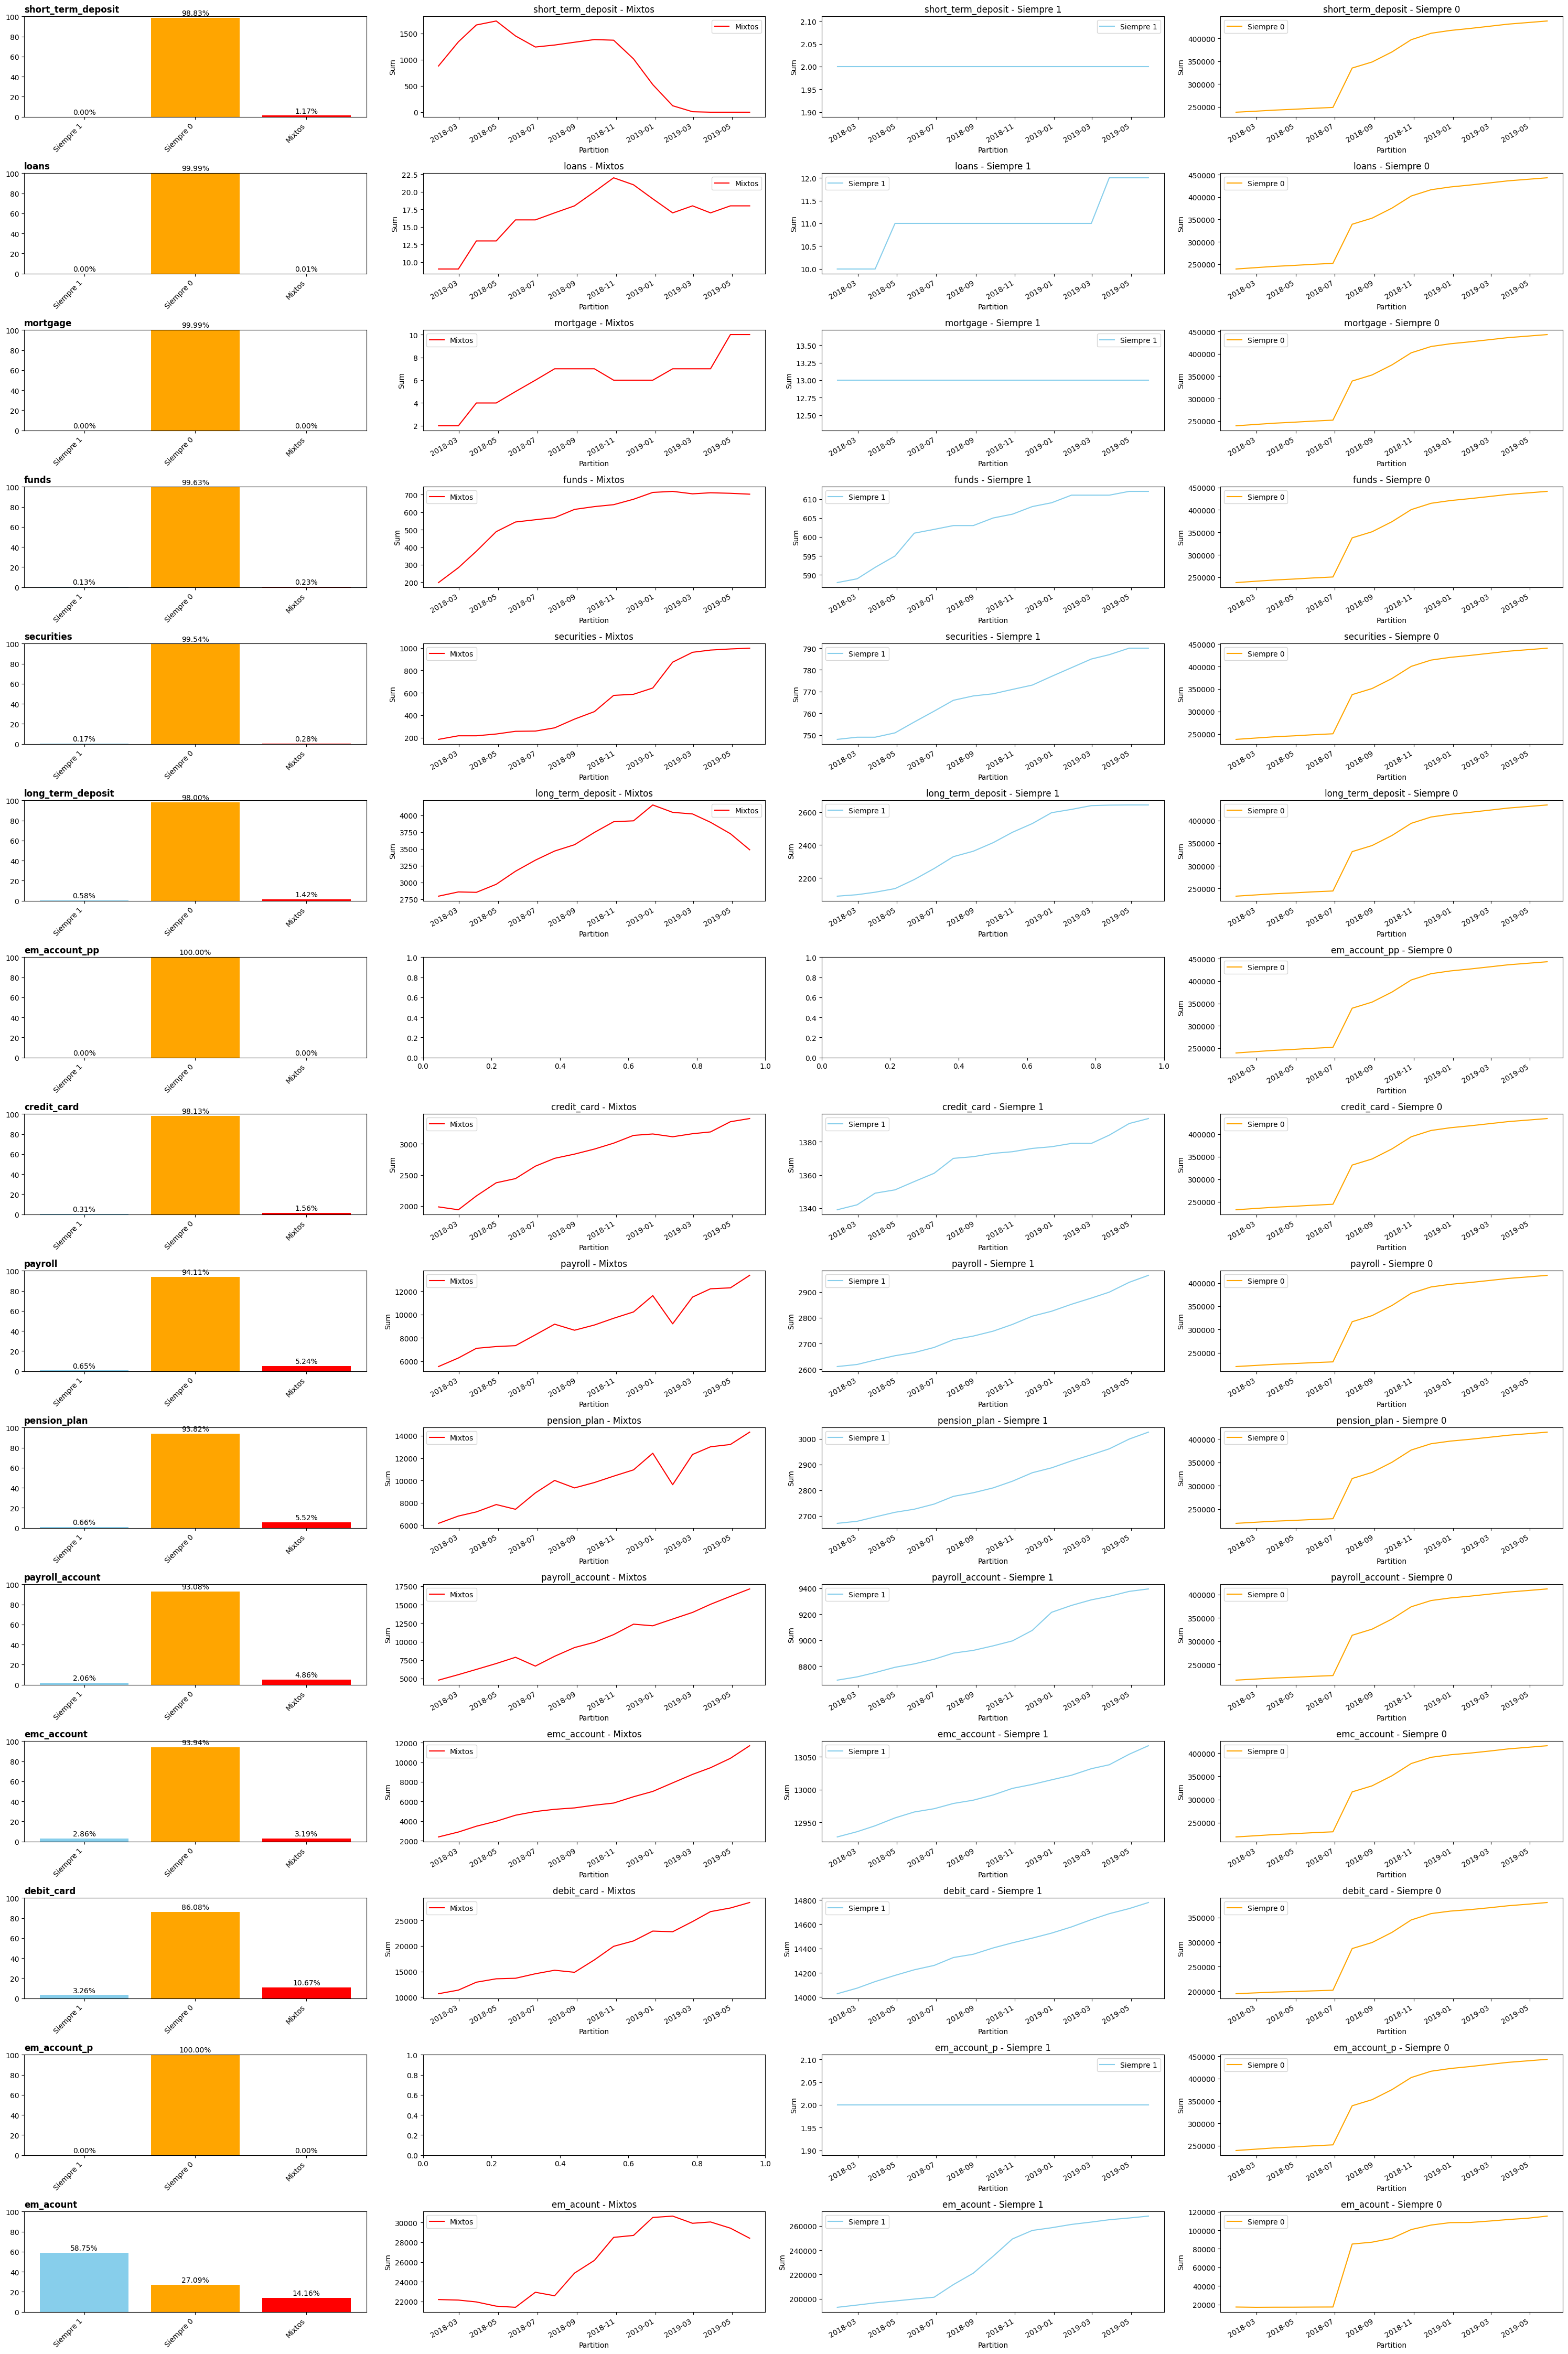

In [18]:
import matplotlib.pyplot as plt

# Número total de clientes en el dataset
total_clientes = prod_df['pk_cid'].nunique()

# Lista de variables a analizar
variables = [
    'short_term_deposit', 'loans', 'mortgage', 'funds', 'securities',
    'long_term_deposit', 'em_account_pp', 'credit_card', 'payroll',
    'pension_plan', 'payroll_account', 'emc_account', 'debit_card',
    'em_account_p', 'em_acount'
]

# Crear una figura grande con 15 filas y 4 columnas de subplots
fig, axes = plt.subplots(nrows=len(variables), ncols=4, figsize=(30, len(variables) * 3))
axes = axes.flatten()  # Aplanar la matriz de ejes para un fácil acceso

for i, var in enumerate(variables):
    # Calcular porcentajes
    pct_siempre_1 = (resultados[var]['siempre_1']['count'] / total_clientes) * 100
    pct_siempre_0 = (resultados[var]['siempre_0']['count'] / total_clientes) * 100
    pct_mixtos = (resultados[var]['mixtos']['count'] / total_clientes) * 100

    # Datos para la barra
    categorias = ['Siempre 1', 'Siempre 0', 'Mixtos']
    valores = [pct_siempre_1, pct_siempre_0, pct_mixtos]

    # Gráfico de barras
    ax_bar = axes[i * 4]
    bars = ax_bar.bar(categorias, valores, color=['skyblue', 'orange', 'red'])
    ax_bar.set_title(f'{var}', loc='left', fontsize=12, fontweight='bold')
    ax_bar.set_ylim(0, 100)

    # Añadir los valores encima de las barras
    for bar in bars:
        yval = bar.get_height()
        ax_bar.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

    # Rotar las etiquetas en el eje x si es necesario
    ax_bar.set_xticklabels(categorias, rotation=45, ha='right')

    # Filtrar los clientes para la variable en la categoría 'mixtos'
    mixtos = prod_df[prod_df["pk_cid"].isin(resultados[var]["mixtos"]["pk_cid"])]

    # Filtrar los clientes para la variable en la categoría 'siempre_1'
    siempre_1 = prod_df[prod_df["pk_cid"].isin(resultados[var]["siempre_1"]["pk_cid"])]

    # Filtrar los clientes para la variable en la categoría 'siempre_0'
    siempre_0 = prod_df[prod_df["pk_cid"].isin(resultados[var]["siempre_0"]["pk_cid"])]

    # Gráfico de líneas para los clientes mixtos
    ax_line_mixtos = axes[i * 4 + 1]
    if not mixtos.empty:
        mixtos.groupby("pk_partition")[var].sum().plot(
            kind='line', ax=ax_line_mixtos, color='red', label='Mixtos')
        ax_line_mixtos.set_title(f'{var} - Mixtos')
        ax_line_mixtos.set_xlabel('Partition')
        ax_line_mixtos.set_ylabel('Sum')
        ax_line_mixtos.legend()

    # Gráfico de líneas para los clientes siempre 1
    ax_line_siempre_1 = axes[i * 4 + 2]
    if not siempre_1.empty:
        siempre_1.groupby("pk_partition")[var].sum().plot(
            kind='line', ax=ax_line_siempre_1, color='skyblue', label='Siempre 1')
        ax_line_siempre_1.set_title(f'{var} - Siempre 1')
        ax_line_siempre_1.set_xlabel('Partition')
        ax_line_siempre_1.set_ylabel('Sum')
        ax_line_siempre_1.legend()

    # Gráfico de líneas para los clientes siempre 0
    ax_line_siempre_0 = axes[i * 4 + 3]
    if not siempre_0.empty:
        siempre_0.groupby("pk_partition")[var].count().plot(
            kind='line', ax=ax_line_siempre_0, color='orange', label='Siempre 0')
        ax_line_siempre_0.set_title(f'{var} - Siempre 0')
        ax_line_siempre_0.set_xlabel('Partition')
        ax_line_siempre_0.set_ylabel('Sum')
        ax_line_siempre_0.legend()

# Ajustar la disposición de los subplots para que no se solapen
plt.tight_layout()

# Mostrar la figura completa
plt.show()

La imagen muestra el comportamiento de cada producto en la empresa. Por cada producto se tiene un primer gráfico que muestra la distribución en porcentaje de los clientes según los que siempre usan el producto, los que no lo usan y los que que tienen un comportamiento variable. La mayoría de los productos financieros analizados parecen tener una gran cantidad de clientes que no utilizan esos productos (Siempre 0). 

Esto podría indicar áreas donde la empresa puede explorar oportunidades para aumentar la adopción de estos productos entre sus clientes. 

Por otro lado, productos como em_acount parecen ser ampliamente utilizados y consistentemente, lo que sugiere una fuerte aceptación y uso continuo por parte de los clientes.

El resto de los gráficos muestran el comportamiento de cada tipo de cliente (los que siempre usan el producto en cuestión, los que no lo usan y los que tienen un comportamiento variable) a lo largo de las particiones:

- Los que no usan el producto presentan un comportamiento similar en cada producto, antes del 2018-07 el comportamiento era estable, pero a partir de ese momento ha habido un aumento en el número de clientes que se están incluyendo en esta categoría.
y una posible una desactivación del uso del producto por parte de algunos clientes.

- Aunque los clientes que siempre usan el producto muestran una tendencia estable, en algunos productos también se ve una ligera inclinación ascendente después de 2018. Esto puede sugerir que, con el tiempo, algunos clientes han empezado a usar consistentemente productos que antes no usaban, lo cual es una señal positiva para la empresa, indicando una mayor adopción y fidelidad en esos productos.

- Los gráficos muestran que el uso de productos entre los clientes con comportamiento variable ha variado, con una tendencia creciente en muchos casos, es decir, al inicio no usaban los productos pero a partir del 2018-07 ha habido mejor aceptación, excepto para productos como em_acount, long term deposit, loans y short term deposit se ha reducido su interés.



